In [1]:
states = [[1,2,3], ['a', 'b', 'c'], [10, 20, 30]]

a_l = []
b_l = []
c_l = []

print(list(zip(*states)))


[(1, 'a', 10), (2, 'b', 20), (3, 'c', 30)]


In [2]:
import numpy as np

data = np.loadtxt("Project_RL/tab_q_val_trajectory.csv", delimiter=",", skiprows=1)
print(data[-3:None])

FileNotFoundError: Project_RL/tab_q_val_trajectory.csv not found.

In [3]:
f = {k: (k+4)*10 for k in range(1, 13)}
l = {k+12: 170 for k in range(1, 13)}
h = f | l
print(h)

{1: 50, 2: 60, 3: 70, 4: 80, 5: 90, 6: 100, 7: 110, 8: 120, 9: 130, 10: 140, 11: 150, 12: 160, 13: 170, 14: 170, 15: 170, 16: 170, 17: 170, 18: 170, 19: 170, 20: 170, 21: 170, 22: 170, 23: 170, 24: 170}


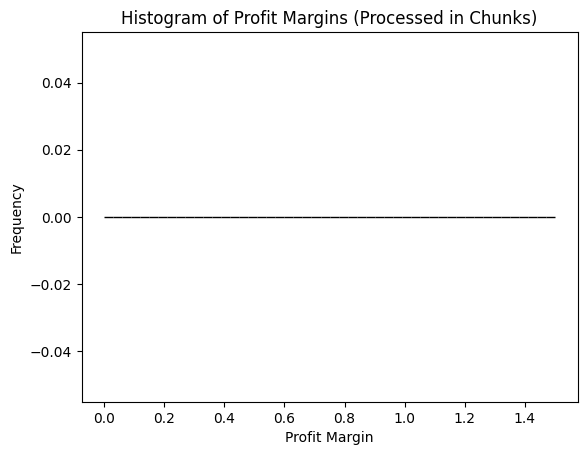

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "Project_RL/tab_q_profit_margins.csv"
column_name = "profit_margin"  # Adjust this based on your file


# Read the file in chunks (assume profit_margin is in the first column)
chunk_size = 10**12  # Adjust based on available memory
chunks = pd.read_csv(file_path, names=[column_name], header=None, chunksize=chunk_size)

df = pd.Series(chunks)
df.to_csv("tab_q_profit_margins_B.csv",index=False)

# Define histogram bins
num_bins = 50
bin_edges = np.linspace(0, 1.5, num_bins + 1)  # Adjust range based on expected values
hist_counts = np.zeros(num_bins)

# Process file chunk by chunk
for chunk in chunks:
    counts, _ = np.histogram(chunk[column_name].dropna(), bins=bin_edges)
    hist_counts += counts  # Accumulate bin counts

# Plot histogram
plt.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), edgecolor="black", align="edge")
plt.xlabel("Profit Margin")
plt.ylabel("Frequency")
plt.title("Histogram of Profit Margins (Processed in Chunks)")
plt.show()



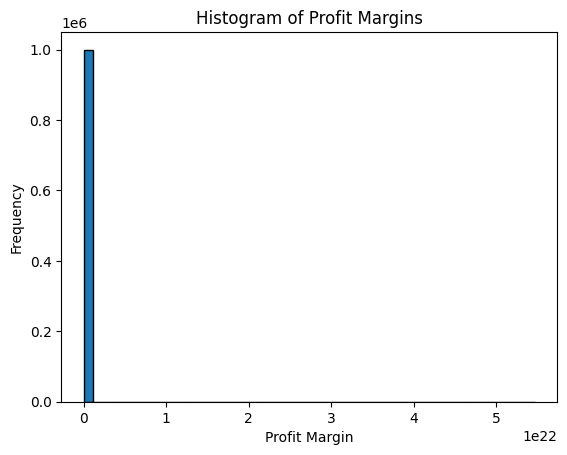

In [3]:
import numpy as np
import matplotlib.pyplot as plt

file_path = "Project_RL/tab_q_profit_margins.csv"

# Memory-map the file (assuming no headers)
data = np.memmap(file_path, dtype="float32", mode="r", shape=(10**6,))  # Adjust shape

# Plot histogram
plt.hist(data, bins=50, edgecolor="black")
plt.xlabel("Profit Margin")
plt.ylabel("Frequency")
plt.title("Histogram of Profit Margins")
plt.show()


/var/folders/8w/0d0hgdy56p38rt558nq5jqt00000gn/T/ipykernel_4494/1826868147.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")
/var/folders/8w/0d0hgdy56p38rt558nq5jqt00000gn/T/ipykernel_4494/1826868147.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


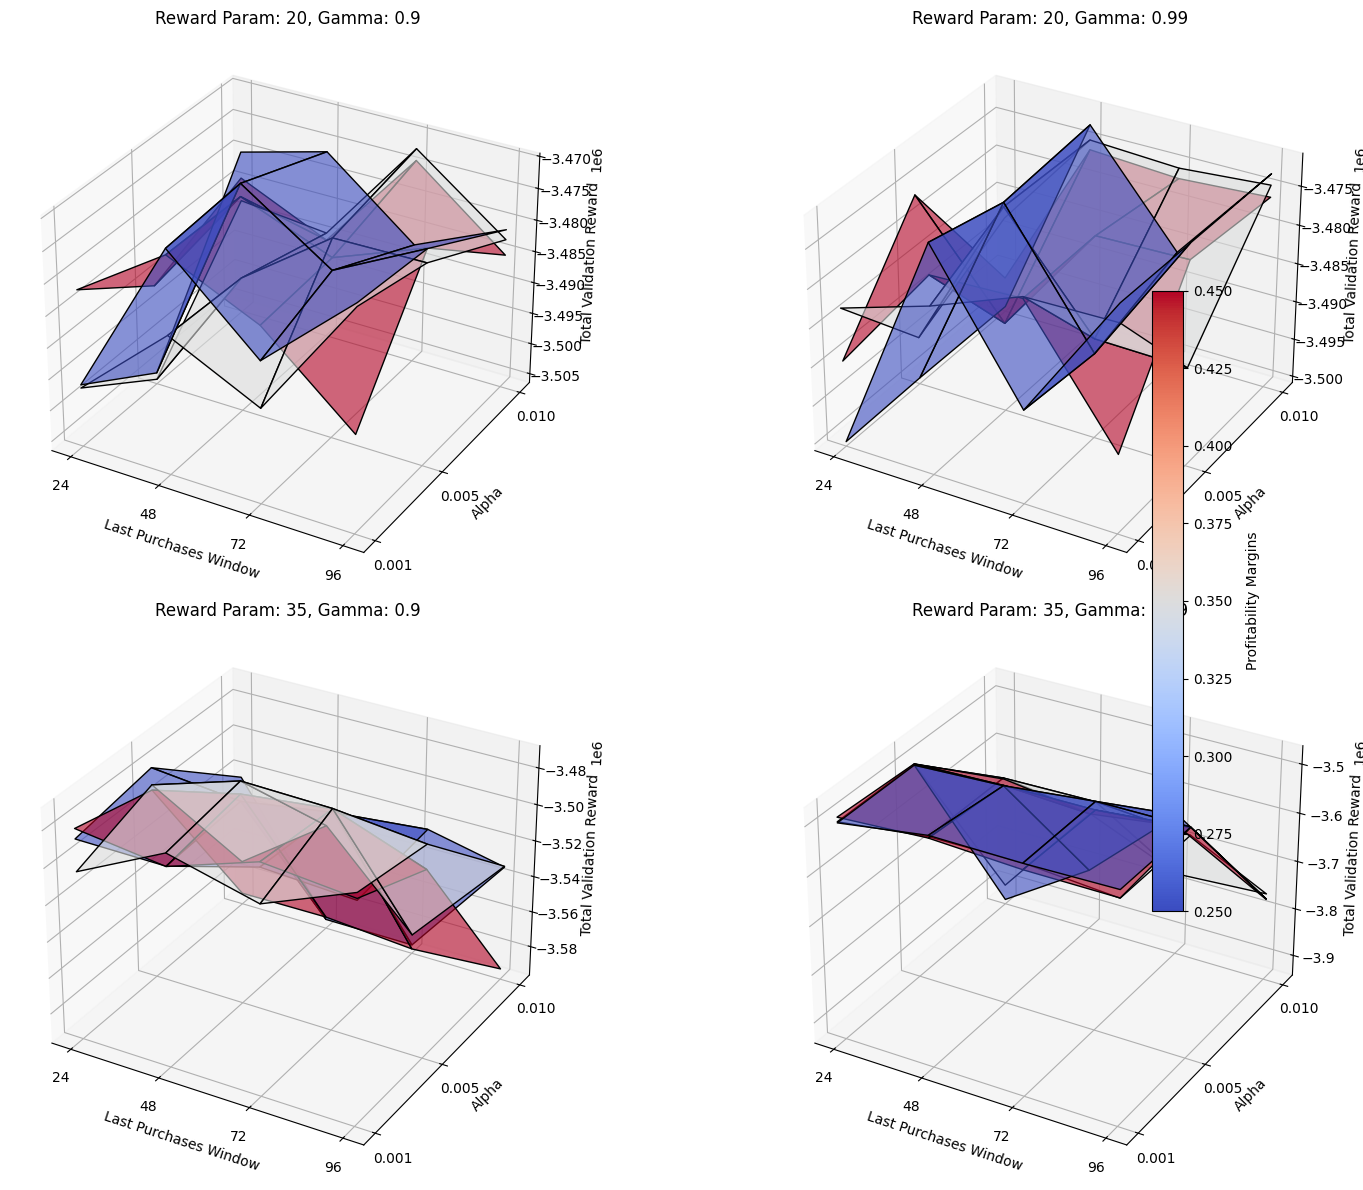

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import cm

def visualize_hyperparam_search(csv_file: str):
    """
    Visualizes the hyperparameter search results using 3D surface plots.

    Each subplot represents a unique combination of (reward_param, gamma),
    with:
      - X-axis: last_purchases_window
      - Y-axis: alpha
      - Z-axis: total validation reward
      - Color: profitability_margins (mapped to a colormap from cold to hot)

    :param csv_file: Path to the CSV file containing hyperparameter search results.
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Extract unique values for reward_param and gamma to create subplots
    reward_params = sorted(df['reward_param'].unique())
    gammas = sorted(df['gamma'].unique())
    
    # Set up 2x2 grid for subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': '3d'})
    
    # Define colormap for profitability_margins
    unique_margins = sorted(df['profitability_margins'].unique())
    norm = plt.Normalize(vmin=min(unique_margins), vmax=max(unique_margins))
    cmap = cm.get_cmap("coolwarm")
    
    # Iterate over reward_param and gamma to generate subplots
    for i, reward_param in enumerate(reward_params):
        for j, gamma in enumerate(gammas):
            ax = axes[i, j]
            
            # Filter data for current (reward_param, gamma) combination
            subset = df[(df['reward_param'] == reward_param) & (df['gamma'] == gamma)]
            
            # Generate surface plot
            for margin in unique_margins:
                data = subset[subset['profitability_margins'] == margin]
                if not data.empty:
                    X_vals = sorted(data['last_purchases_window'].unique())
                    Y_vals = sorted(data['alpha'].unique())
                    X, Y = np.meshgrid(X_vals, Y_vals)
                    Z = np.array([[data[(data['last_purchases_window'] == x) & (data['alpha'] == y)]['total validation reward'].mean() 
                                   for x in X[0]] for y in Y[:, 0]])
                    
                    color_value = cmap(norm(margin))
                    facecolors = np.full(X.shape + (4,), color_value)  # Ensure facecolors has the correct shape
                    ax.plot_surface(X, Y, Z, facecolors=facecolors, shade=False, edgecolor='k', alpha=0.6)
            
            # Set labels and title
            ax.set_xlabel('Last Purchases Window')
            ax.set_ylabel('Alpha')
            ax.set_zlabel('Total Validation Reward')
            ax.set_title(f"Reward Param: {reward_param}, Gamma: {gamma}")
            
            # Adjust axis limits for better readability
            ax.set_xticks(sorted(df['last_purchases_window'].unique()))
            ax.set_yticks(sorted(df['alpha'].unique()))
            
    # Create the colorbar legend for profitability_margins
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.025, pad=0.1)
    cbar.set_label("Profitability Margins", rotation=90, labelpad=10)
    
    plt.tight_layout()
    plt.show()

# Example usage
# visualize_hyperparam_search("hyper_param_tab_q_val_test.csv")


 
 

# Example usage
visualize_hyperparam_search("Project_RL/hyper_param_tab_q_val_test.csv")
